In [25]:

import numpy as np 
import pandas as pd 

import os
print(os.listdir("."))

['out (1)', 'pre.ipynb', 'requirements.txt']


In [26]:
import numpy as np #for covering the text to vectors
import pandas as pd# for the dataframe
from music21 import converter, corpus, instrument, midi, note, chord, pitch,stream,roman 
#for analysis of the MIDI files to understand the structure of the file
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
#to plot the analysis
# from multiprocessing.dummy import Pool as ThreadPool # Use this when IO is the problem
from multiprocessing import Pool # Use this when CPU-intensive functions are the problem.
import gensim, logging
#use for the WORD2VEC model to find the similarity relationship between the similar chords
import pprint

In [27]:
import music21

def read_midi_file(filepath):
    '''
    Reads a MIDI file and returns a music21 Score object.

    Parameters:
    filepath (str): The path to the MIDI file to read.

    Returns:
    music21.stream.Score: The music21 Score object representing the MIDI file.
    '''
    # Load the MIDI file into a music21 Stream object
    midi_stream = music21.converter.parse(filepath)

    return midi_stream
base_midi = read_midi_file('out (1)/001---Shankar-Ehsaan-Loy,-Clinton-Cerejo,-Dominique-Cerejo,-Loy-Mendonsa---Kya-Karoon_basic_pitch.mid')
base_midi

<music21.stream.Score 0x178a4d92560>

In [28]:
#function to list the number of tracks
#basic pitch already only extracts the melody
def list_instruments(midi):
    partStream = midi.parts.stream()
    print("List of instruments found on MIDI file:")
    for p in partStream:
        aux = p
        print (p.partName)

list_instruments(base_midi)

List of instruments found on MIDI file:
Electric Piano


C:\Users\sassm\AppData\Local\Temp\ipykernel_12652\18138550.py:7: StreamIteratorInefficientWarning: flat is not defined on StreamIterators. Call .stream() first for efficiency
  for nt in midi_part.flat.notes:


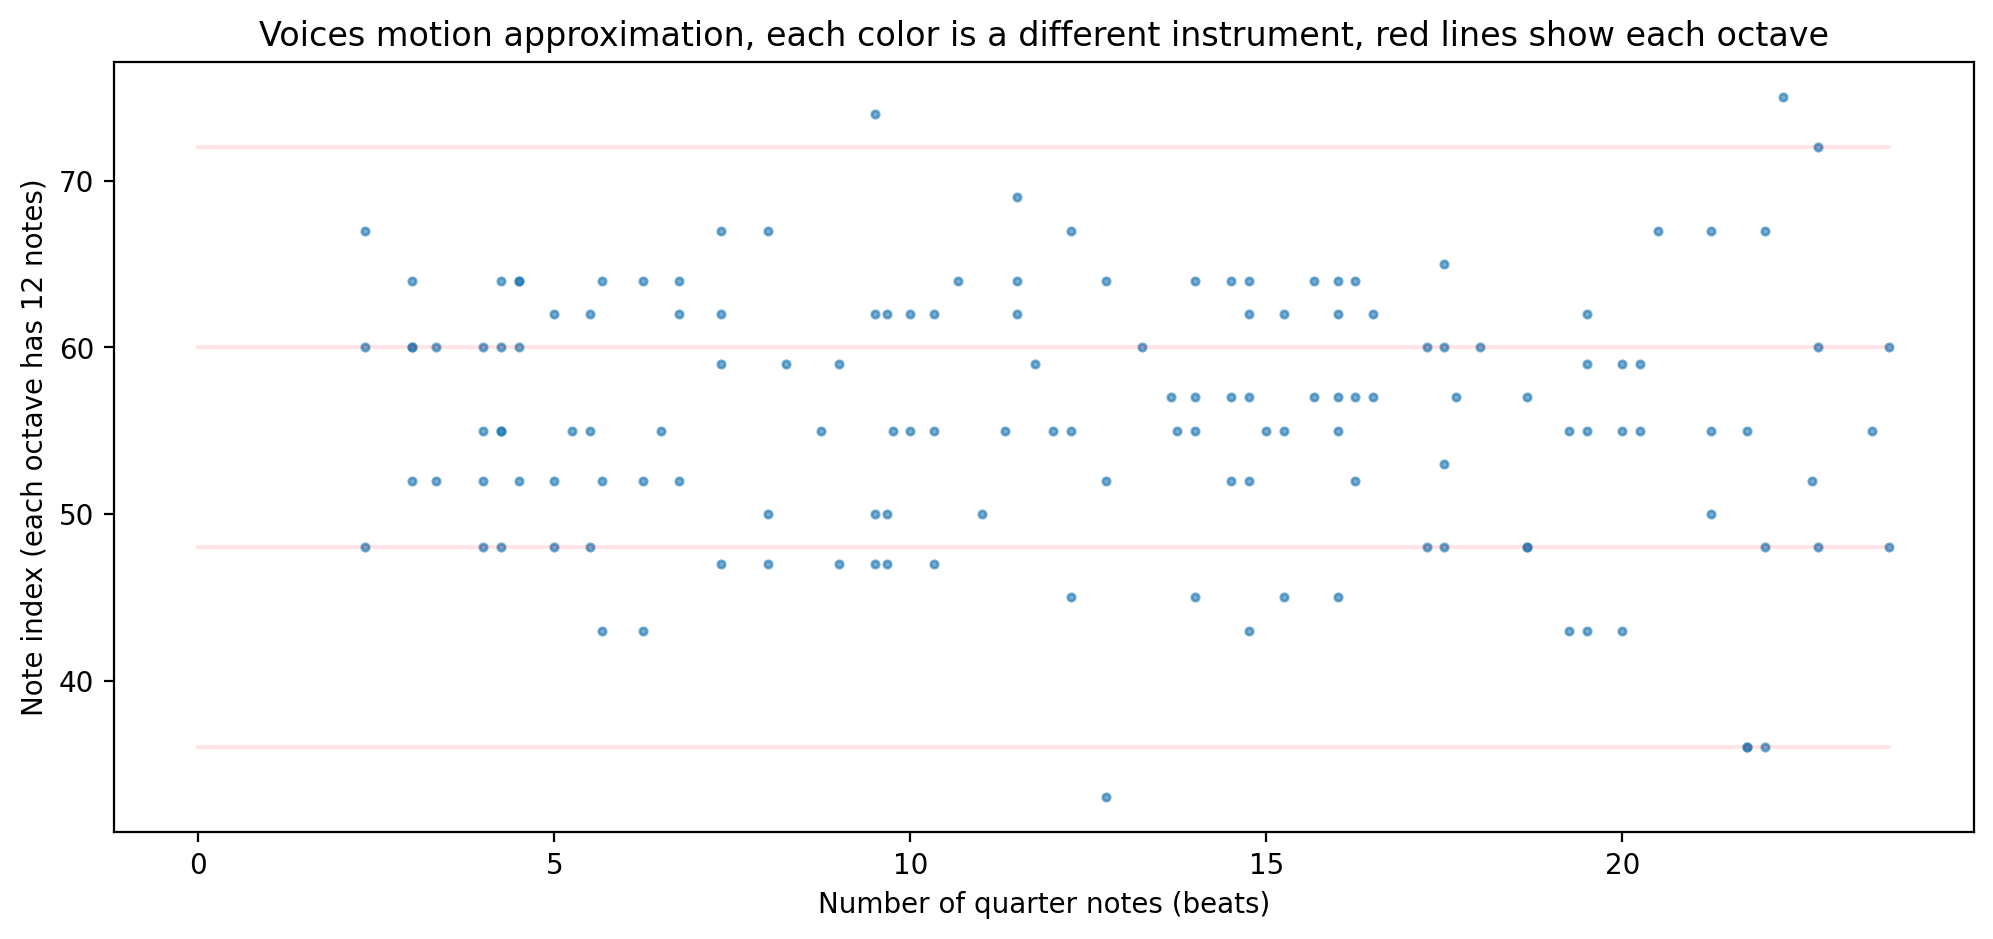

In [29]:
#import matplotlib.pyplot as plt
#import matplotlib.lines as mlines
# Extract the notes from the file and Visualizing the results
def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element

def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    
    # Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))            

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.show()

# Focusing only on 6 first measures to make it easier to understand.
print_parts_countour(base_midi.measures(0, 6))

In [30]:
#extracting the other informations like Time Signature, key Signature,Music key confidence
timeSignature = base_midi.getTimeSignatures()[0]
music_analysis = base_midi.analyze('key')
print("Music time signature: {0}/{1}".format(timeSignature.beatCount, timeSignature.denominator))
print("Expected music key: {0}".format(music_analysis))
print("Music key confidence: {0}".format(music_analysis.correlationCoefficient))
print("Other music key alternatives:")
for analysis in music_analysis.alternateInterpretations:
    if (analysis.correlationCoefficient > 0.5):
        print(analysis)

Music time signature: 4/4
Expected music key: C major
Music key confidence: 0.873178596788477
Other music key alternatives:
a minor
F major
d minor
G major
g minor


C:\Users\sassm\AppData\Local\Temp\ipykernel_12652\18138550.py:7: StreamIteratorInefficientWarning: flat is not defined on StreamIterators. Call .stream() first for efficiency
  for nt in midi_part.flat.notes:


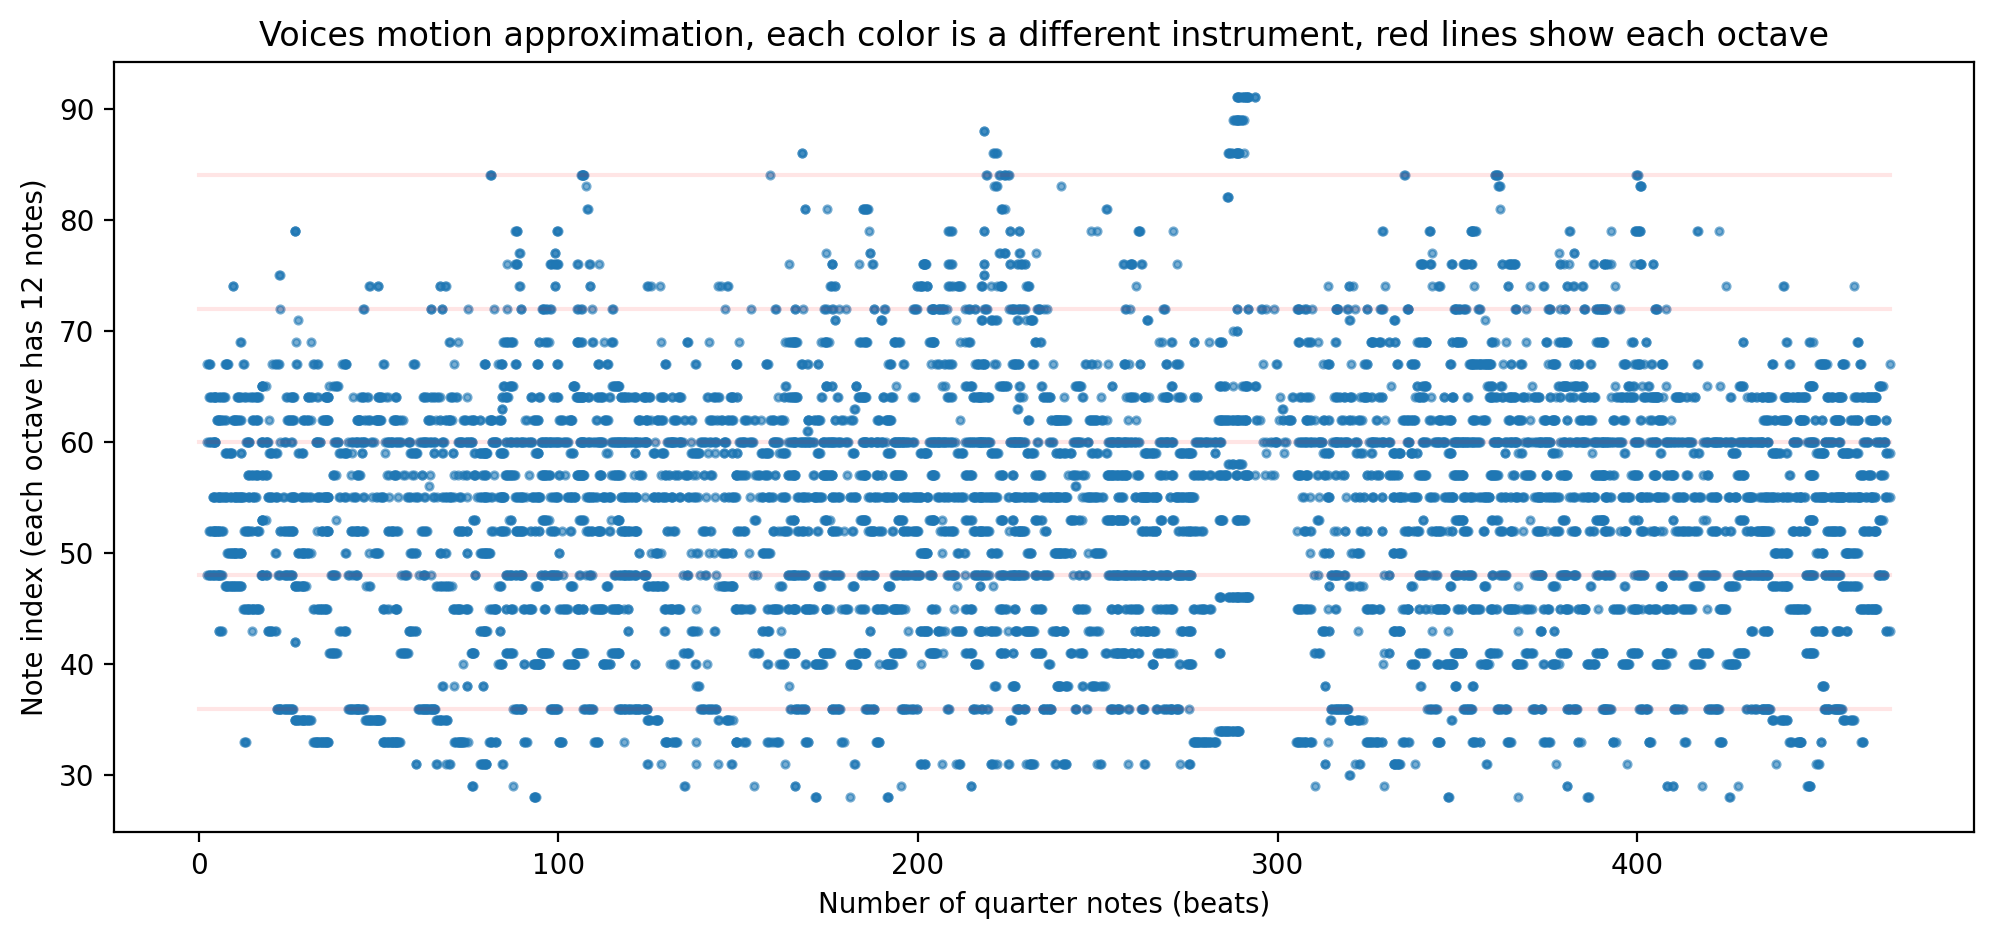

{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.ElectricPiano 'Electric Piano'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark animato Quarter=120.0>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Rest 7/3ql>
    {2.3333} <music21.chord.Chord C3 C4 G4>
    {2.8333} <music21.chord.Chord C3 G4>
    {3.0} <music21.chord.Chord C3 E3 C4 E4 G4>
    {3.25} <music21.chord.Chord C3 E3 C4 E4 G4>
    {3.3333} <music21.chord.Chord C3 E3 C4 E4>
    {3.8333} <music21.chord.Chord C3 E4>


In [31]:
#from music21 import stream

#visualizing the chords extracted
temp_midi_chords = read_midi_file('out (1)/001---Shankar-Ehsaan-Loy,-Clinton-Cerejo,-Dominique-Cerejo,-Loy-Mendonsa---Kya-Karoon_basic_pitch.mid').chordify()
temp_midi = stream.Score()
temp_midi.insert(0, temp_midi_chords)

# Printing merged tracks.
print_parts_countour(temp_midi)

# Dumping first measure notes
temp_midi_chords.measures(0, 1).show("text")

In [47]:
#from music21 import roman


#performing harmonic reduction on the Midi file
def note_count(measure, count_dict):
    bass_note = None
    for chord in measure.recurse().getElementsByClass('Chord'):
        # All notes have the same length of its chord parent.
        note_length = chord.quarterLength
        for note in chord.pitches:          
            # If note is "C5", note.name is "C". We use "C5"
            # style to be able to detect more precise inversions.
            note_name = str(note) 
            if (bass_note is None or bass_note.ps > note.ps):
                bass_note = note
                
            if note_name in count_dict:
                count_dict[note_name] += note_length
            else:
                count_dict[note_name] = note_length
        
    return bass_note
                
def simplify_roman_name(roman_numeral):
    # Chords can get nasty names as "bII#86#6#5",
    # in this method we try to simplify names, even if it ends in
    # a different chord to reduce the chord vocabulary and display
    # chord function clearer.
    ret = roman_numeral.romanNumeral
    inversion_name = None
    inversion = roman_numeral.inversion()
    
    # Checking valid inversions.
    if ((roman_numeral.isTriad() and inversion < 3) or
            (inversion < 4 and
                 (roman_numeral.seventh is not None or roman_numeral.isSeventh()))):
        inversion_name = roman_numeral.inversionName()
        
    if (inversion_name is not None):
        ret = ret + str(inversion_name)
        
    elif (roman_numeral.isDominantSeventh()): ret = ret + "M7"
    elif (roman_numeral.isDiminishedSeventh()): ret = ret + "o7"
    return ret
                
def harmonic_reduction(midi_file):
    ret = []
    temp_midi = stream.Score()
    temp_midi_chords = midi_file.chordify()
    temp_midi.insert(0, temp_midi_chords)    
    music_key = temp_midi.analyze('key')
    max_notes_per_chord = 4   
    for m in temp_midi_chords.measures(0, None): # None = get all measures.
        if (type(m) != stream.Measure):
            continue
        
        # Here we count all notes length in each measure,
        # get the most frequent ones and try to create a chord with them.
        count_dict = dict()
        bass_note = note_count(m, count_dict)
        if (len(count_dict) < 1):
            ret.append("-") # Empty measure
            continue
        
        sorted_items = sorted(count_dict.items(), key=lambda x:x[1])
        sorted_notes = [item[0] for item in sorted_items[-max_notes_per_chord:]]
        measure_chord = chord.Chord(sorted_notes)
        
        # Convert the chord to the functional roman representation
        # to make its information independent of the music key.
        roman_numeral = roman.romanNumeralFromChord(measure_chord, music_key)
        ret.append(simplify_roman_name(roman_numeral))
        
    return ret

harmonic_reduction(base_midi)[0:10]
     

['I53', 'I', 'V6', 'vi7', 'IV64', 'i7', 'I', 'vii', 'v', 'iv']

In [53]:
# # Don't run this code again...please...I will cry 
# # Set the directory path containing the MIDI files
# midi_dir = 'out (1)'

# # Get a list of all the MIDI files in the directory
# midi_files = [os.path.join(midi_dir, file) for file in os.listdir(midi_dir) if file.endswith('.mid')]

# # Create an empty data frame to store the MIDI file information
# midi_df = pd.DataFrame(columns=['song_name', 'key_signature	', 'harmonic_red'])

# # Loop through each MIDI file and extract the relevant information
# # Loop through each MIDI file and extract the relevant information
# for file in midi_files:
#     midi_data = read_midi_file(file)
#     key_signature = midi_data.analyze('key')
#     hr_list = harmonic_reduction(midi_data)
#     song_name = os.path.basename(file)
    
#     # Add the information to the data frame
#     midi_df = midi_df.append({'song_name': song_name, 'key_signature': key_signature, 'harmonic_red': hr_list}, ignore_index=True)


# # Print the data frame
# midi_df


,song_name,key_signature\t,harmonic_red,key_signature
0,"708---Vishal-Shekhar,-KK---Tu-Aashiqui-Hai_bas...",NaN,"[vi42, V, v, vi65, vi65, IV, IV, i, v, V53, vi...",D major
1,709---Rahat-Fateh-Ali-Khan---Jiya-Dhadak-Dhada...,NaN,"[i, vi42, v, iii, iii, iii, v, iii, I42, iii, ...",C major
2,710---Bombay-Jayashri---Zara-Zara_basic_pitch.mid,NaN,"[i, v, ii64, VI53, i, v53, iv6, i, vii, i43, V...",b minor
3,711---Atif-Aslam---Woh-Lamhe-Woh-Baatein_basic...,NaN,"[IV, ii43, IV, iv, biv, ii, biv64, biv, v42, i...",B major
4,712---KK---Such-Keh-Raha-Hai_basic_pitch.mid,NaN,"[III42, bI, ii42, i, i, bI, bI, iv, bIV, bI, i...",b minor
...,...,...,...,...
253,"974---Guru-Randhawa,-Neha-Kakkar,-Tanishk-Bagc...",NaN,"[v, v, III, III53, III, v, v, III, III53, III,...",d minor
254,"975---Badshah,-Diljit-Dosanjh,-Aastha-Gill---P...",NaN,"[bIV, VI, i, i53, VI53, biii, i, VI53, i, VI6,...",c# minor
255,"976---Pritam,-Arijit-Singh,-Amitabh-Bhattachar...",NaN,"[iv7, i, i, iv7, i, iv7, I64, V, IV7, i, IV7, ...",C major
256,"977---Tanishk-Bagchi,-Udit-Narayan,-Alka-Yagni...",NaN,"[-, -, -, v, -, v, v, -, bvii, bi, -, v, bvii,...",E major


In [55]:
# # Don't run this code again...please...I will cry 
# #The above code gave error in between so i have to run it again to get the output, hence joining the output of both the runs
# midi_df1 = pd.read_csv('midi_df.csv')
# midi_df2 = midi_df1.append(midi_df)
# midi_df2.to_csv('midi.csv', index=False)
# df = pd.read_csv('midi.csv')
# df


In [69]:
# # Don't run this code again...please...I will cry 
# df = pd.read_csv('midi.csv')
# df=df.drop(['key_signature	'], axis=1)
# df = df.drop(['Unnamed: 0'], axis=1)


,song_name,harmonic_red,key_signature
0,"001---Shankar-Ehsaan-Loy,-Clinton-Cerejo,-Domi...","['I53', 'I', 'V6', 'vi7', 'IV64', 'i7', 'I', '...",C major
1,"002---Amit-Trivedi,-Kavita-Seth,-Amitabh-Bhatt...","['v', 'vi42', 'vi65', 'vi6', 'vi65', 'vi65', '...",G major
2,"003---Amit-Trivedi,-Alia-Bhatt---Love-You-Zind...","['i', 'i', 'vi', 'i', 'i', 'i', 'vi43', 'i', '...",E- major
3,"004---Jawad-Ahmad,-Shaarib-Toshi,-Alia-Bhatt--...","['vi65', 'i', 'I', 'IV64', 'iv', 'vi65', 'vi7'...",B- major
4,"006---Amit-Trivedi,-Arijit-Singh---Tu-Hi-Hai_b...","['iv', 'i', 'IV43', 'iv', 'i', 'I53', 'i', 'vi...",E major
...,...,...,...
937,"974---Guru-Randhawa,-Neha-Kakkar,-Tanishk-Bagc...","['v', 'v', 'III', 'III53', 'III', 'v', 'v', 'I...",d minor
938,"975---Badshah,-Diljit-Dosanjh,-Aastha-Gill---P...","['bIV', 'VI', 'i', 'i53', 'VI53', 'biii', 'i',...",c# minor
939,"976---Pritam,-Arijit-Singh,-Amitabh-Bhattachar...","['iv7', 'i', 'i', 'iv7', 'i', 'iv7', 'I64', 'V...",C major
940,"977---Tanishk-Bagchi,-Udit-Narayan,-Alka-Yagni...","['-', '-', '-', 'v', '-', 'v', 'v', '-', 'bvii...",E major


In [70]:
# # Don't run this code again...please...I will cry 
# df.to_csv('Final_midi.csv', index=False)

In [71]:
df=pd.read_csv('Final_midi.csv')
# import modules & set up logging
import gensim, logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
 
model = gensim.models.Word2Vec(df["harmonic_red"], min_count=2, window=4) #Word2vec model is used to train the dataframe chords
#for identification of similar chords

In [76]:
# def vectorize_harmony(model, hrr):
#     # Gets the model vector values for each chord from the reduction.
#     word_vecs = []
#     for word in hrr:
#         try:
#             vec = model[word]
#             word_vecs.append(vec)
#         except KeyError:
#             # Ignore, if the word doesn't exist in the vocabulary
#             pass
    
#     # Assuming that document vector is the mean of all the word vectors.
#     return np.mean(word_vecs, axis=0)

# def cosine_similarity(vecA, vecB):
#     # Find the similarity between two vectors based on the dot product.
#     csim = np.dot(vecA, vecB) / (np.linalg.norm(vecA) * np.linalg.norm(vecB))
#     if np.isnan(np.sum(csim)):
#         return 0
    
#     return csim

# def calculate_similarity_aux(df, model, source_names=[], target_names=[], threshold=0):
#     final_results = []
#     for sname in source_names:
#         source_harmo = df[df["song_name"] == sname]["harmonic_red"].values[0]
#         source_vec = vectorize_harmony(model, source_harmo)
#         results = []
#         if (len(source_harmo) == 0):
#                 continue
#         for name in target_names:
#             target_harmo = df[df["song_name"] == name]["harmonic_red"].values[0]
#             if (len(target_harmo) == 0):
#                 continue
            
#             target_vec = vectorize_harmony(model, target_harmo)       
#             sim_score = cosine_similarity(source_vec, target_vec)
#             if sim_score > threshold:
#                 results.append({
#                     'score' : sim_score,
#                     'sourcename' : sname,
#                     'targetname' : name,
#                     'sourceChord'  : source_harmo,
#                     'targetChord'  : target_harmo
#                 })
                
#         # Sort results by score in desc order
#         results.sort(key=lambda k : k['score'] , reverse=True)
#         final_results.append(results)
#     return final_results

# def calculate_similarity(df, model, source_sufix, target_sufix, threshold=0):
#     source_midi_names = df[df["song_name"].str.endswith(source_sufix)]["song_name"].values 
#     if (len(source_midi_names) == 0):
#         print("Invalid source name")
#         return
    
#     #source_midi_name = source_midi_names[0]
    
#     target_midi_names = df[df["song_name"].str.endswith(target_sufix)]["song_name"].values  
#     if (len(target_midi_names) == 0):
#         print("Invalid target prefix")
#         return
    
#     return calculate_similarity_aux(df, model, source_midi_names, target_midi_names, threshold)



# similarity_records = calculate_similarity(df, model, "mid", "mid") 

TypeError: 'Word2Vec' object is not subscriptable